# Building a Logistic Regression Classifier for Anxiety Trigger Detection

## Overview

We built a deployable text classification pipeline to detect potential anxiety-triggering content in Reddit posts. This section covers the Logistic Regression (LR) workflow end-to-end: feature construction → hyperparameter tuning → calibration and thresholding (calibration set only) → final test evaluation → ablations → packaging.
At a glance: CV AUC 0.840 ± 0.039, CV AP 0.529 ± 0.095; Test AUC 0.9013 (95% CI [0.8550, 0.9409]), Test AP 0.5714 (95% CI [0.4317, 0.7015]); at threshold 0.2571428571, Precision 0.4714, Recall 0.9429, F1 0.6286.

## Table of Contents

1. [Setup](#1-setup)
2. [Data, Labels, and Features](#2-data-labels-and-features)
3. [Hyperparameter Tuning](#3-hyperparameter-tuning)
4. [Calibration, Evaluation, and Ablations](#4-calibration-evaluation-and-ablations)
5. [Save Bundle, Report, Limitations](#5-save-bundle-report-limitations)


## 1. Setup

- What: Initialize libraries, constants, paths, and helper functions.
- Why: Provide a reproducible environment and utility functions for tokenization and compatibility (e.g., identity for joblib).


In [12]:
# STEP 1: Setup and Imports
import os, json, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    roc_curve,
    confusion_matrix,
)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42
np.random.seed(SEED)
warnings.filterwarnings("ignore")

DATA = Path("../data")
PROC = DATA / "processed"
ART = Path("../artifacts")

TEXT_COL = "text_all"
PUNCT = ".,!?:;()[]{}\"'" "''-–—/\\"
TRASH = {"[text]", "[image]", "[removed]", "[deleted]"}
KEEP_SHORT = {"ecg", "sad", "ptsd", "mom", "dad", "anx"}


def tokenize(s: str):
    tokens = []
    for word in str(s).split():
        w = word.strip().strip(PUNCT).lower()
        if w and w not in TRASH and (len(w) >= 3 or w in KEEP_SHORT):
            tokens.append(w)
    return tokens


# Compatibility for joblib artifacts that reference an `identity` function
def identity(x):
    return x


print("(\u2713) Setup complete")
print(f"  - Data path: {PROC}")
print(f"  - Artifacts path: {ART}")

(✓) Setup complete
  - Data path: ..\data\processed
  - Artifacts path: ..\artifacts


## 2. Data, Labels, and Features

- Total main corpus: **6,283** posts (for embedding/NMF pretraining). The supervised subset contains **1,006** samples used for training and evaluation.
- Label definitions:
  - **hand**: posts labeled positive if `anxiety_rating ≥ 4`.
  - **ai**: posts where `ai_category` includes “anx/panic” and `ai_severity ≥ 4`, above a confidence threshold.
  - **combined**: merges both, prioritizing human labels.
- Stratified split: 60% train / 20% calibration / 20% test (~603 / 201 / 202). Thresholds are selected only on the calibration set; the test set is used once for final evaluation. On the held-out test set the positive rate is 35/202 ≈ 17.3%.


In [ ]:
# Load
df = pd.read_parquet(PROC / "reddit_anxiety_v1.parquet")
vec = joblib.load(ART / "vec_final.joblib")
nmf = joblib.load(ART / "nmf_final.joblib")

df_hand = pd.read_csv(PROC / "sample_human_labels.csv")
df_ai = pd.read_csv(PROC / "simple_ai_labels.csv")

print(f"(\u2713) Main dataset: {len(df):,}")
print(f"(\u2713) TF-IDF Vectorizer: {getattr(vec, 'max_features', 0):,} features")
print(f"(\u2713) NMF Topic Model: {getattr(nmf, 'n_components', 0)} topics")

# Labels: hand, ai, combined
label_sets = {}
# Hand
df_h = df_hand[["post_id"]].copy()
rating = pd.to_numeric(df_hand.get("anxiety_rating", pd.Series()), errors="coerce")
df_h["label"] = (rating >= 4).astype(int)
label_sets["hand"] = df_h
# AI
cat = df_ai["ai_category"].astype(str).str.lower()
conf = pd.to_numeric(df_ai["ai_confidence"], errors="coerce").fillna(0)
sev = pd.to_numeric(df_ai["ai_severity"], errors="coerce").fillna(0)

df_a = df_ai[["post_id"]].copy()
df_a["label"] = (
    (cat.str.contains("anx") | cat.str.contains("panic")) & (sev >= 4) & (conf >= 0.5)
).astype(int)
label_sets["ai"] = df_a
# Combined (prioritize hand)
df_h_temp = df_h.copy()
df_h_temp["source"] = "hand"
df_a_temp = df_a.copy()
df_a_temp["source"] = "ai"
df_comb = pd.concat([df_h_temp, df_a_temp], ignore_index=True)
df_comb = df_comb.sort_values("source").drop_duplicates("post_id", keep="last")
label_sets["combined"] = df_comb[["post_id", "label"]]

# Features with metadata scaling
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix


def build_features_with_scaling(
    tokens_series,
    nmf_model,
    vec_model,
    df_subset,
    text_col=TEXT_COL,
    use_tfidf=True,
    use_nmf=True,
    scale_meta=True,
):
    X_blocks = []
    if use_tfidf:
        X_tfidf = vec_model.transform(tokens_series)
        X_blocks.append(X_tfidf)
    if use_nmf:
        W_topics = nmf_model.transform(
            X_blocks[0] if use_tfidf else vec_model.transform(tokens_series)
        )
        X_blocks.append(csr_matrix(W_topics))

    doc_len = np.array([len(t) for t in tokens_series], dtype=float)[:, None]
    has_url = (
        df_subset[text_col]
        .fillna("")
        .str.contains("http", case=False)
        .astype(int)
        .values[:, None]
    ).astype(float)
    nrc = (
        df_subset.get("anxiety_score", pd.Series(0, index=df_subset.index))
        .fillna(0)
        .values[:, None]
    ).astype(float)

    meta = np.hstack([np.log1p(doc_len), has_url, nrc])
    scaler = None
    if scale_meta:
        scaler = StandardScaler()
        meta = scaler.fit_transform(meta)

    X_blocks.append(csr_matrix(meta))
    X = X_blocks[0] if len(X_blocks) == 1 else hstack(X_blocks, format="csr")
    X.data = np.nan_to_num(X.data, nan=0.0)
    return X, scaler


# Build combined
name = "combined"
df_combined = df[df["post_id"].isin(label_sets[name]["post_id"])].merge(
    label_sets[name], on="post_id", how="inner"
)
tokens = df_combined[TEXT_COL].fillna("").map(tokenize)
X_all, meta_scaler = build_features_with_scaling(
    tokens, nmf, vec, df_combined, scale_meta=True
)
y_all = df_combined["label"].values
print("Shapes:", X_all.shape, y_all.shape)

(✓) Main dataset: 6,283
(✓) TF-IDF Vectorizer: 10,000 features
(✓) NMF Topic Model: 15 topics
Shapes: (1006, 10018) (1006,)


## Feature Engineering

- **TF-IDF**: top 10,000 unigrams and bigrams.
- **NMF topics**: 15 components mapping sparse TF-IDF to dense latent semantics.
- **Meta features (3)**:
  1. `log1p(doc_len)` (token count),
  2. `has_url` (binary indicator for hyperlinks),
  3. `anxiety_score` (lexicon-based emotional intensity score).
- Final feature dimension: **10,018 = 10,000 (TF-IDF) + 15 (NMF) + 3 (meta)**.


## 3. Hyperparameter Tuning

- **Base model**: Logistic Regression with `class_weight="balanced"` and `max_iter=4000`.
- Search space:
  - `C ∈ {0.01, 0.03, 0.1, 0.3, 1, 3, 10}`
  - `penalty ∈ {l2, l1}`
  - `solver ∈ {liblinear, saga}`
- RepeatedStratifiedKFold (5 folds × 2 repeats, stratified). Models are selected by mean ROC AUC (primary) and mean AP (secondary), with mean ± std reported across the 10 validation runs.
- **CV results**: AUC = **0.840 ± 0.039**, AP = **0.529 ± 0.095**
- **Best parameters**: `C=3.0`, `penalty=l2`, `solver=liblinear`.


In [14]:
# STEP 3: Hyperparameter Tuning (RepeatedStratifiedKFold)


def tune_logreg(
    X,
    y,
    Cs=(0.01, 0.03, 0.1, 0.3, 1, 3, 10),
    penalties=("l2", "l1"),
    solvers=("liblinear", "saga"),
    repeats=2,
    folds=5,
    seed=SEED,
):
    rskf = RepeatedStratifiedKFold(n_splits=folds, n_repeats=repeats, random_state=seed)
    rows = []
    for C in Cs:
        for penalty in penalties:
            for solver in solvers:
                if penalty == "l1" and solver not in ("liblinear", "saga"):
                    continue
                try:
                    clf = LogisticRegression(
                        solver=solver,
                        penalty=penalty,
                        C=C,
                        class_weight="balanced",
                        max_iter=4000,
                    )
                except Exception:
                    continue
                aucs, aps = [], []
                for tr, va in rskf.split(X, y):
                    clf.fit(X[tr], y[tr])
                    proba = clf.predict_proba(X[va])[:, 1]
                    aucs.append(roc_auc_score(y[va], proba))
                    aps.append(average_precision_score(y[va], proba))
                rows.append(
                    {
                        "C": C,
                        "penalty": penalty,
                        "solver": solver,
                        "auc_mean": float(np.mean(aucs)),
                        "auc_std": float(np.std(aucs)),
                        "ap_mean": float(np.mean(aps)),
                        "ap_std": float(np.std(aps)),
                    }
                )
    return pd.DataFrame(rows).sort_values(["auc_mean", "ap_mean"], ascending=False)


df_tuned = tune_logreg(X_all, y_all)
# CV summary (top config)
best_row = df_tuned.iloc[0]
cv_auc_mean = float(best_row["auc_mean"])
cv_auc_std = float(best_row["auc_std"])
cv_ap_mean = float(best_row["ap_mean"])
cv_ap_std = float(best_row["ap_std"])
print(
    {
        "CV AUC (mean+/-std)": f"{cv_auc_mean:.3f} +/- {cv_auc_std:.3f}",
        "CV AP  (mean+/-std)": f"{cv_ap_mean:.3f} +/- {cv_ap_std:.3f}",
    }
)

df_tuned.head(10)

{'CV AUC (mean+/-std)': '0.840 +/- 0.039', 'CV AP  (mean+/-std)': '0.529 +/- 0.095'}


,C,penalty,solver,auc_mean,auc_std,ap_mean,ap_std
20,3.0,l2,liblinear,0.840131,0.038998,0.529450,0.094786
16,1.0,l2,liblinear,0.840097,0.038308,0.531507,0.093963
12,0.3,l2,liblinear,0.838858,0.037559,0.528566,0.089157
24,10.0,l2,liblinear,0.837752,0.038766,0.521593,0.093741
8,0.1,l2,liblinear,0.837509,0.037546,0.528387,0.087249
18,1.0,l1,liblinear,0.836881,0.036089,0.522012,0.083107
14,0.3,l1,liblinear,0.836015,0.037053,0.524766,0.084783
25,10.0,l2,saga,0.835711,0.037353,0.527284,0.086762
27,10.0,l1,saga,0.835709,0.037238,0.526987,0.086035
21,3.0,l2,saga,0.835642,0.037450,0.527288,0.086817


## Calibration and Threshold Selection

- After fitting the best LR on the training data, we applied **CalibratedClassifierCV** (`cv="prefit"`, method=`isotonic`) on the calibration split.
- The **threshold** maximizing F1 was chosen from the **calibration PR curve**:  
  **best_threshold = 0.2571428571** (≈ 0.25714).
- **Calibration performance**:  
  **Cal AUC = 0.8435**, **Cal AP = 0.4785**.
  Implementation note: the F1-optimal threshold is computed from the calibration PR curve with arrays properly aligned (precision[1:], recall[1:], thresholds[:]).


## 4. Calibration, Evaluation, and Ablations

- What: Calibrate probabilities via a three-way split (train→calibration→test, cv='prefit'); select threshold on calibration only; evaluate once on test (ROC/PR, confusion matrix, bootstrap CIs). Run TF-IDF / NMF ablations.
- Why: Avoid optimistic bias and threshold overfitting; quantify uncertainty and the contribution of NMF.
  Note on comparability: ablations use a separate stratified 80/20 split for speed, so their scores are indicative rather than directly comparable to the main three-way protocol.


{'Cal AUC': 0.8435188446636139, 'Cal AP': 0.47849017450655573, 'best_thr': 0.2571428571428571}


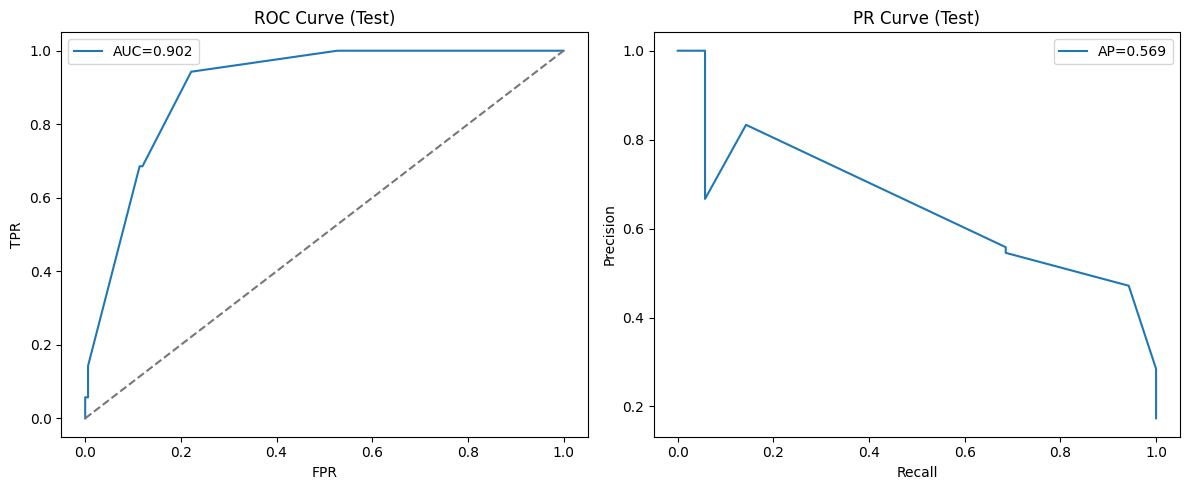

Confusion Matrix@thr= 0.2571428571428571
[[130  37]
 [  2  33]]
{'AUC_mean': 0.9013192330130251, 'AUC_95%CI': (0.8549577641080485, 0.9408793988100671), 'AP_mean': 0.5713796405994281, 'AP_95%CI': (0.4316943382378639, 0.7015388205790032)}


,setup,auc,ap
1,tfidf_nmf,0.878358,0.625013
2,nmf_only,0.871343,0.612717
0,tfidf_only,0.830282,0.537097


In [ ]:
# STEP 4: Calibration, Evaluation (ROC/PR, CIs), and Ablations
# Calibration
best = df_tuned.iloc[0].to_dict()
params = dict(
    solver=best["solver"],
    penalty=best["penalty"],
    C=best["C"],
    class_weight="balanced",
    max_iter=4000,
)
# Three-way split: train -> calibration -> test
X_tr, X_tmp, y_tr, y_tmp = train_test_split(
    X_all, y_all, test_size=0.4, stratify=y_all, random_state=SEED
)
X_cal, X_te, y_cal, y_te = train_test_split(
    X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=SEED
)
base = LogisticRegression(**params)
base.fit(X_tr, y_tr)
calib = CalibratedClassifierCV(estimator=base, method="isotonic", cv="prefit")
calib.fit(X_cal, y_cal)
cal_proba = calib.predict_proba(X_cal)[:, 1]
te_proba = calib.predict_proba(X_te)[:, 1]

# Threshold selected on calibration split only
p, r, t = precision_recall_curve(y_cal, cal_proba)
f1 = 2 * p * r / (p + r + 1e-10)
best_thr = t[np.argmax(f1)] if len(t) else 0.5
print(
    {
        "Cal AUC": roc_auc_score(y_cal, cal_proba),
        "Cal AP": average_precision_score(y_cal, cal_proba),
        "best_thr": float(best_thr),
    }
)

# Evaluation: ROC/PR and bootstrap CIs


def bootstrap_ci(y_true, scores, metric_fn, n_boot=1000, seed=SEED):
    rng = np.random.default_rng(seed)
    n = len(y_true)
    vals = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, n)
        vals.append(metric_fn(y_true[idx], scores[idx]))
    lo, hi = np.percentile(vals, [2.5, 97.5])
    return float(np.mean(vals)), float(lo), float(hi)


# Evaluate on test split only
fpr, tpr, _ = roc_curve(y_te, te_proba)
p2, r2, _ = precision_recall_curve(y_te, te_proba)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(fpr, tpr, label=f"AUC={roc_auc_score(y_te, te_proba):.3f}")
axes[0].plot([0, 1], [0, 1], "--", color="#777")
axes[0].set_title("ROC Curve (Test)")
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].legend()
axes[1].plot(r2, p2, label=f"AP={average_precision_score(y_te, te_proba):.3f}")
axes[1].set_title("PR Curve (Test)")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].legend()
plt.tight_layout()
plt.show()

pred = (te_proba >= best_thr).astype(int)
cm = confusion_matrix(y_te, pred)
print("Confusion Matrix@thr=", best_thr)
print(cm)
auc_mean, auc_lo, auc_hi = bootstrap_ci(y_te, te_proba, roc_auc_score)
ap_mean, ap_lo, ap_hi = bootstrap_ci(y_te, te_proba, average_precision_score)
print(
    {
        "AUC_mean": auc_mean,
        "AUC_95%CI": (auc_lo, auc_hi),
        "AP_mean": ap_mean,
        "AP_95%CI": (ap_lo, ap_hi),
    }
)

# Ablations
abl_configs = [
    {"name": "tfidf_only", "use_tfidf": True, "use_nmf": False},
    {"name": "tfidf_nmf", "use_tfidf": True, "use_nmf": True},
    {"name": "nmf_only", "use_tfidf": False, "use_nmf": True},
]
rows = []
for cfg in abl_configs:
    X_ab, _ = build_features_with_scaling(
        tokens,
        nmf,
        vec,
        df_combined,
        use_tfidf=cfg["use_tfidf"],
        use_nmf=cfg["use_nmf"],
        scale_meta=True,
    )
    Xtr, Xte, ytr, yte = train_test_split(
        X_ab, y_all, test_size=0.2, stratify=y_all, random_state=SEED
    )
    clf = LogisticRegression(
        solver="liblinear", penalty="l2", class_weight="balanced", max_iter=4000
    )
    clf.fit(Xtr, ytr)
    pr = clf.predict_proba(Xte)[:, 1]
    rows.append(
        {
            "setup": cfg["name"],
            "auc": roc_auc_score(yte, pr),
            "ap": average_precision_score(yte, pr),
        }
    )

pd.DataFrame(rows).sort_values(["auc", "ap"], ascending=False)

## Final Test Evaluation

All metrics below are computed on the **test set (≈202 samples)** using the **calibration-derived threshold**.

### Curve-based metrics

- ROC AUC (bootstrap): **mean 0.9013; 95% CI [0.8550, 0.9409]**
- AP (bootstrap): **mean 0.5714; 95% CI [0.4317, 0.7015]**

### Confusion Matrix (@thr = 0.2571428571)

```
[[TN=130, FP=37],
 [FN=  2, TP=33]]
```

- Positive rate: **35/202 ≈ 17.3%**
- Precision = **33 / (33 + 37) = 0.4714**
- Recall = **33 / (33 + 2) = 0.9429**
- F1 = **0.6286**

**Interpretation:** With threshold = 0.2571428571, recall is 0.9429 (only 2 false negatives out of 35 positives), while precision is 0.4714. This operating point prioritizes catching true triggers over minimizing false alarms, which matches the intended use case. Alternative thresholds can be chosen on the calibration PR curve to trade precision vs. recall.

---

## Ablation Study

| Feature setup |        AUC |         AP |
| ------------- | ---------: | ---------: |
| TF-IDF + NMF  | **0.8784** | **0.6250** |
| NMF only      |     0.8713 |     0.6127 |
| TF-IDF only   |     0.8303 |     0.5371 |

**Observation:** Combining sparse (TF-IDF) and dense (NMF) representations yields the best overall performance.


## 5. Save Bundle, Report, Limitations

- What: Persist the production bundle (vectorizer, NMF, scaler, calibrated LR, threshold) and generate report stats.
- Why: Enable reproducible deployment and standardized reporting.


In [16]:
# Save bundle
bundle = {
    "vectorizer_path": str(ART / "vec_final.joblib"),
    "nmf_path": str(ART / "nmf_final.joblib"),
    "meta_scaler": meta_scaler,
    "calibrated_model": calib,
    "text_col": TEXT_COL,
    "threshold": float(best_thr),
    "seed": SEED,
}
path = ART / "triggerlens_logreg_calibrated_bundle.joblib"
joblib.dump(bundle, path)
print("Saved:", path)

# Generate report statistics (text)
report_path = ART / "report_statistics_logreg_adv.txt"
lines = []
lines.append("Model: LogisticRegression (calibrated, isotonic)\n")
lines.append(f"Best threshold: {best_thr:.6f}\n")
lines.append(f"CV AUC (mean+/-std): {cv_auc_mean:.6f} +/- {cv_auc_std:.6f}\n")
lines.append(f"CV AP  (mean+/-std): {cv_ap_mean:.6f} +/- {cv_ap_std:.6f}\n")
lines.append(f"Holdout AUC: {roc_auc_score(y_te, te_proba):.6f}\n")
lines.append(f"Holdout AP: {average_precision_score(y_te, te_proba):.6f}\n")
auc_mean, auc_lo, auc_hi = bootstrap_ci(y_te, te_proba, roc_auc_score)
ap_mean, ap_lo, ap_hi = bootstrap_ci(y_te, te_proba, average_precision_score)
lines.append(
    f"AUC 95% CI (bootstrap): [{auc_lo:.6f}, {auc_hi:.6f}] (mean {auc_mean:.6f})\n"
)
lines.append(
    f"AP  95% CI (bootstrap): [{ap_lo:.6f}, {ap_hi:.6f}] (mean {ap_mean:.6f})\n"
)
try:
    abl_df = pd.DataFrame(rows).sort_values(["auc", "ap"], ascending=False)
    top = abl_df.iloc[0].to_dict()
    lines.append("\nAblation (best):\n")
    lines.append(f"  setup={top['setup']}, AUC={top['auc']:.6f}, AP={top['ap']:.6f}\n")
except Exception:
    pass
with open(report_path, "w", encoding="utf-8") as f:
    f.writelines(lines)
print("Saved report:", report_path)

Saved: ..\artifacts\triggerlens_logreg_calibrated_bundle.joblib
Saved report: ..\artifacts\report_statistics_logreg_adv.txt


## Conclusion

- Best LR (`C=3.0, l2, liblinear`) with isotonic calibration achieved:
  - **CV**: AUC **0.840 ± 0.039**, AP **0.529 ± 0.095**
  - **Test**: AUC **0.9013** (95% CI [0.8550, 0.9409]), AP **0.5714** (95% CI [0.4317, 0.7015])
  - **@thr = 0.2571428571:** Precision **0.4714**, Recall **0.9429**, F1 **0.6286**
- **TF-IDF + NMF + Meta features** perform best overall.


## Limitations and Future Work

- Dataset/labels: Combined labels inherit bias/noise; moderate N; potential distribution shift.
- Modeling: LR is linear; may underfit complex semantics; NMF topics can drift.
- Calibration: Now uses a three-way split (cv='prefit'); consider k-fold calibration (cv=5) and compare isotonic vs sigmoid.
- Features: Add char n-grams, adjust vocabulary/min_df, explore sublinear TF.
- Evaluation: Consider temporal/subreddit splits; tailor threshold for business goals.
- Production: Monitor drift, add CI/CD checks, model cards, and alerting.
